<a href="https://colab.research.google.com/github/WeeenChiii/NTHU_2023_DLBOI_HW/blob/main/hw2_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## HW2 Report

##### 110066515 陳文祺

</div>


In [4]:
# # Download dataset
#!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
#!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy

--2023-10-16 05:55:31--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy.1’

normal.npy.1        100%[===================>]  62.50M   262MB/s    in 0.2s    

2023-10-16 05:55:31 (262 MB/s) - ‘normal.npy.1’ saved [65536128/65536128]

--2023-10-16 05:55:31--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

## A. Data Loading and Preprocessing

In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 900

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')

x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')
print(f'Y_train: max value is {y_train.max().item()}, min value is {y_train.min().item()}, data type is {y_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Shape of x_train: (1800, 256, 256)
Shape of y_train: (1800,)
Number of samples in train and validation are 1800 and 200.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Y_train: max value is 1, min value is 0, data type is torch.int64.


## B. Defining Neural Networks in PyTorch

In [80]:
import torch.nn as nn

# Model in Lab 2
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(256*256*1, 256),
#     nn.ReLU(),
#     nn.Linear(256, 1)
# ).cuda()

model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0),

    nn.Linear(64, 2)      # for CE
    #nn.Linear(64, 1)     # for BCE
).cuda()

print(model)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0, inplace=False)
  (13): Linear(in_features=64, out_features=2, bias=True)
)


## C. Training the Neural Network

In [81]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
#criterion = nn.BCEWithLogitsLoss() # for BCE
criterion = nn.CrossEntropyLoss()   # for CE

optimizer = optim.Adam(model.parameters(), lr=3e-6)
#lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=4, gamma=0.4)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.0
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        #labels = labels.float().unsqueeze(1) # for BCE
        labels = labels.long() # for CE

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        #train_predicted = torch.sigmoid(outputs) > 0.5  # for BCE
        train_predicted = outputs.argmax(-1)  # for CE

        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            #labels = labels.float().unsqueeze(1) # for BCE
            labels = labels.long() # for CE

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            #predicted = torch.sigmoid(outputs) > 0.5   # for BCE
            predicted = outputs.argmax(-1)  # for CE
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)



Epoch 1/30, Train Loss: 0.5749, Train Accuracy: 70.72%, Val Loss: 0.6444, Val Accuracy: 50.00%
Epoch 2/30, Train Loss: 0.4415, Train Accuracy: 86.61%, Val Loss: 0.5566, Val Accuracy: 79.00%
Epoch 3/30, Train Loss: 0.3906, Train Accuracy: 91.28%, Val Loss: 0.4269, Val Accuracy: 85.50%
Epoch 4/30, Train Loss: 0.3568, Train Accuracy: 93.33%, Val Loss: 0.3644, Val Accuracy: 90.00%
Epoch 5/30, Train Loss: 0.3457, Train Accuracy: 94.56%, Val Loss: 0.3531, Val Accuracy: 94.00%
Epoch 6/30, Train Loss: 0.3329, Train Accuracy: 94.89%, Val Loss: 0.3502, Val Accuracy: 91.00%
Epoch 7/30, Train Loss: 0.3319, Train Accuracy: 95.00%, Val Loss: 0.3369, Val Accuracy: 90.00%
Epoch 8/30, Train Loss: 0.3203, Train Accuracy: 95.17%, Val Loss: 0.3287, Val Accuracy: 91.50%
Epoch 9/30, Train Loss: 0.3277, Train Accuracy: 95.89%, Val Loss: 0.3377, Val Accuracy: 93.50%
Epoch 10/30, Train Loss: 0.3175, Train Accuracy: 95.61%, Val Loss: 0.3402, Val Accuracy: 93.00%
Epoch 11/30, Train Loss: 0.3124, Train Accuracy: 

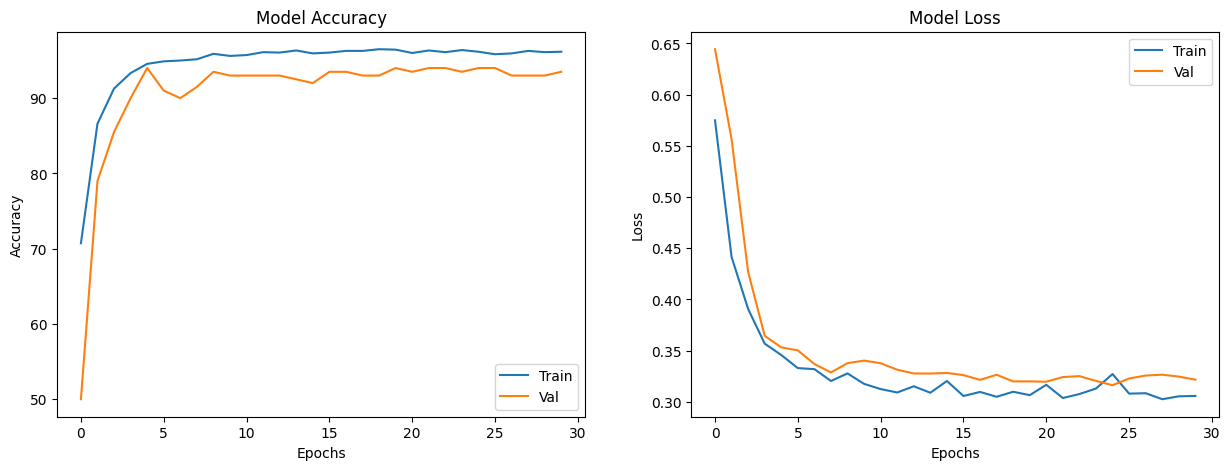

In [82]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

In [57]:
#!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
#!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

import numpy as np

test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')


Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


In [61]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert to PyTorch tensors
x_test = torch.Tensor(x_test).float()
y_test = torch.Tensor(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [83]:
# Declare the model architecture
model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0),

    nn.Linear(64, 2)  # for CE
    #nn.Linear(64, 1) # for BCE
).cuda()


# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0, inplace=False)
  (13): Linear(in_features=64, out_features=2, bias=True)
)

In [84]:
test_correct = 0
test_total = 0


with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()

        outputs = model(images)

        #labels_float = labels.float().unsqueeze(1)  # for BCE
        labels_float = labels.long()  # for CE

        #predicted = torch.sigmoid(outputs) > 0.5 # for BCE
        predicted = outputs.argmax(-1)  # for CE

        test_correct += (predicted.float() == labels_float).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%.')


Test accuracy is 82.25%.
